In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

In [2]:
from datasets.density_datasets import Datasets as DensityDatasets
import numpy as np

X, l = DensityDatasets.aggregation.standardized_data_cached

In [3]:
from src.Cluster.DPC.cluster import DensityPeakCluster
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN

l_dpc = DensityPeakCluster(anormal=False).fit(X).labels_
l_hdbscan = HDBSCAN().fit(X).labels_

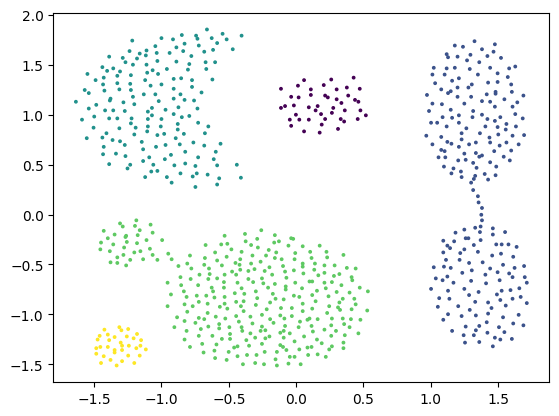

In [4]:
import matplotlib.pyplot as plt

ax = plt.scatter(X[:, 0], X[:, 1], s=3, c=l_hdbscan)
plt.show()

In [6]:
from src.Evaluation import disco_score

disco_score(X, l), disco_score(X, l_dpc), disco_score(X, l_hdbscan)

(0.3056510576364597, 0.5138099180630531, 0.669704899865715)

In [47]:
from src.Evaluation.dcdistances.dctree import DCTree

dctree = DCTree(X, min_points=5, min_points_mr=1)
dctree.min_points = 5

In [59]:
e = dctree.get_edges(dctree.root)
o = np.empty(len(e), dtype=([("i", int), ("j", int), ("dist", float)]))
o[:] = e[:,0]
o

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [7]:
len(X)

788

In [22]:
dctree

DCNode #1574 (0.4709452532592795) - 1
   // #region
   DCNode #1573 (0.4696032264571974) - 2
      // #region
      DCNode #1572 (0.4378593487335549) - 3
         // #region
         DCNode #1570 (0.14636280941880245) - 5
            // #region
            DCNode #1566 (0.11858625406110732) - 7
               // #region
               DCNode #1565 (0.11750422440562969) - 7
                  // #region
                  DCNode #1564 (0.11697647027053183) - 7
                     // #region
                     DCNode #0 (None) - -5
                     // #endregion
                     // #region
                     DCNode #1563 (0.11614195461218425) - 11
                        // #region
                        DCNode #1562 (0.11451520906350404) - 7
                           // #region
                           DCNode #1560 (0.11080276773114775) - 8
                              // #region
                              DCNode #1556 (0.10886455731054806) - 11
                      

In [14]:
[len(dctree.traverse_until_k(i)) for i in range(1,15)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [20]:
for i in range(1,16):
    print(dctree.traverse_until_k(i))
    print()

{DCNode #1574 (0.4709452532592795) - 1}

{DCNode #1573 (0.4696032264571974) - 2, DCNode #1561 (0.11106123718564412) - 13}

{DCNode #1573 (0.4696032264571974) - 2, DCNode #1521 (0.09660240012820875) - 52, DCNode #1548 (0.10513449388213555) - 26}

{DCNode #1573 (0.4696032264571974) - 2, DCNode #1521 (0.09660240012820875) - 52, DCNode #1170 (0.07059479893236512) - 743, DCNode #1459 (0.08780724168818209) - 542}

{DCNode #1373 (0.08181103370877879) - 182, DCNode #1170 (0.07059479893236512) - 743, DCNode #1573 (0.4696032264571974) - 2, DCNode #1463 (0.08789646234344337) - 108, DCNode #1459 (0.08780724168818209) - 542}

{DCNode #1314 (0.0783813015576749) - 229, DCNode #1170 (0.07059479893236512) - 743, DCNode #1573 (0.4696032264571974) - 2, DCNode #1463 (0.08789646234344337) - 108, DCNode #1018 (0.061105606152161554) - 344, DCNode #1459 (0.08780724168818209) - 542}

{DCNode #1309 (0.07816279363646023) - 664, DCNode #982 (0.059151580926880436) - 782, DCNode #1170 (0.07059479893236512) - 743, D

In [24]:
dctree.traverse_until_k(8)

{DCNode #1416 (0.084470516920715) - 147,
 DCNode #1483 (0.09097520559004084) - 88,
 DCNode #1501 (0.09350323282582454) - 70,
 DCNode #1535 (0.10067406892582315) - 39,
 DCNode #1544 (0.10274247049570202) - 30,
 DCNode #1558 (0.11075933238156521) - 16,
 DCNode #1561 (0.11106123718564412) - 13}

In [359]:
dctree.traverse_remove_noise(dctree.root, dctree.root.k)

In [143]:
eps = dctree.get_eps_for_k(7)
print(eps)

l_dbscan = DBSCAN(eps).fit(X).labels_

0.12018544887349755


In [144]:
set(l_dbscan)

{-1, 0, 1, 2, 3, 4, 5, 6}

In [150]:
l_kcenter = dctree.get_k_center(7)

[DCNode #1561 (0.11106123718564412) - 14, DCNode #1558 (0.11075933238156521) - 17, DCNode #1416 (0.084470516920715) - 159, DCNode #1550 (0.1055881461508994) - 25, DCNode #1566 (0.11858625406110732) - 9]


In [149]:
set(l_kcenter)

{-1, 0, 1, 2, 3, 4}

In [147]:
len(set(l_kcenter)), len(set(l_dbscan))

(6, 8)

In [141]:
from sklearn.metrics import adjusted_rand_score as ARI, normalized_mutual_info_score as NMI

ARI(l_dbscan, l_kcenter), NMI(l_dbscan, l_kcenter)

(0.9986721688897341, 0.996515201796731)

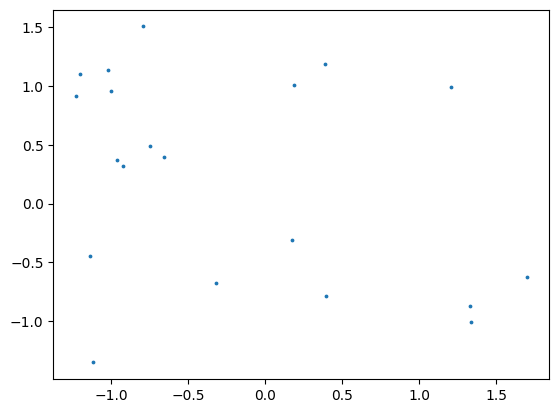

ValueError: 'c' argument has 788 elements, which is inconsistent with 'x' and 'y' with size 20.

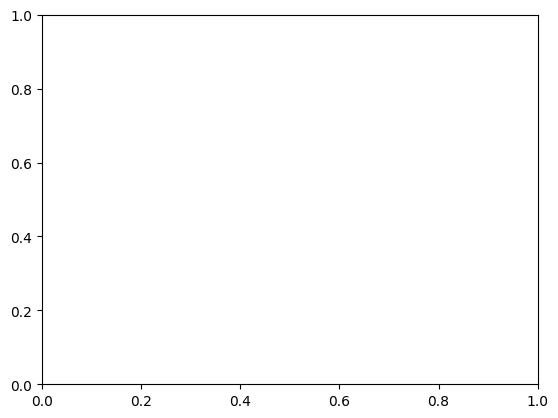

In [181]:
import matplotlib.pyplot as plt

ax = plt.scatter(X_[:, 0], X_[:, 1], s=3, c=l_dbscan)
plt.show()

import matplotlib.pyplot as plt

ax = plt.scatter(X_[:, 0], X_[:, 1], s=3, c=l_kcenter)
plt.show()

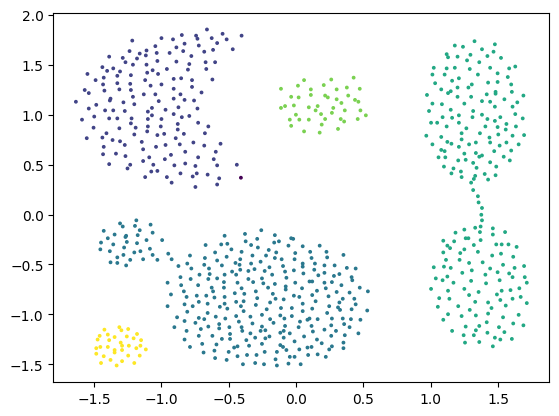

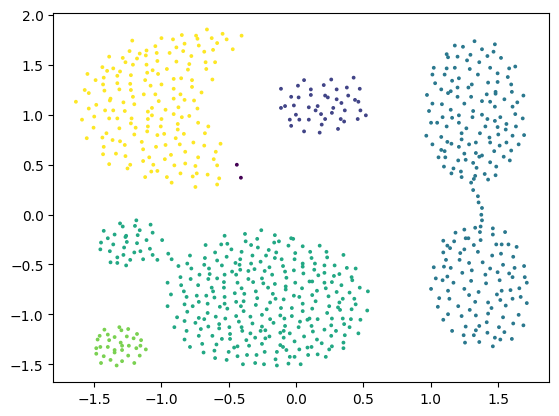

In [142]:
import matplotlib.pyplot as plt

ax = plt.scatter(X[:, 0], X[:, 1], s=3, c=l_dbscan)
plt.show()

import matplotlib.pyplot as plt

ax = plt.scatter(X[:, 0], X[:, 1], s=3, c=l_kcenter)
plt.show()